# Benchmarking h5repack Format on smaller files

This is a HDF5 format that has been rechunked from the original format from NSIDC with `h5repack`
via the following libraries: h5py, h5coro and xarray

## Workflow 1 - Read full group

### Setup Steps

NOTE, below we use the `h5repack` directory, this should be replaced if you are working with a different dataset.

In [3]:
# Checkout the files
# !mamba install -c conda-forge awscli -y
!aws s3 ls s3://nasa-cryo-scratch/h5cloud/h5repack_sm/

2023-08-14 21:12:27  560823635 ATL03_20220201060852_06261401_005_01.h5
2023-08-14 21:12:40  568000000 ATL03_20220201060852_06261401_005_01_repacked.h5


In [75]:
# Create a list of s3 objects
import h5py
import numpy as np
import pandas as pd
import s3fs
import tqdm
import xarray as xr
import earthaccess
import time

try: 
    from h5coro import h5coro, s3driver, filedriver
except:
    !mamba install -c conda-forge h5coro --yes
    from h5coro import h5coro, s3driver, filedriver

# show full columns
pd.set_option('display.max_colwidth', None)

s3 = s3fs.S3FileSystem(anon=False)

group = '/gt2l/heights'
variable = 'h_ph'

We could use earthaccess to directly open a granule if we know the file name. For now we are just using one previously pre processed with h5repack

In [68]:
# earthaccess.login()
# granule = earthaccess.search_data(
#     short_name="ATL03",
#     granule_name="ATL03_20220201060852_06261401_005_01.h5",
#     cloud_hosted=True
# )
# display(granule[0])

In [76]:
path = "s3://nasa-cryo-scratch/h5cloud/h5repack_rnd/"

repacked =  ["s3://nasa-cryo-scratch/h5cloud/h5repack_rnd/ATL03_20220201060852_06261401_005_01_repacked.h5"]
original =  ["s3://nasa-cryo-scratch/h5cloud/h5repack_rnd/ATL03_20220201060852_06261401_005_01.h5"]


### Option 1: Read the original file with `h5py` 

In [77]:
%%time
 
benchmarks = []

tool = "h5py"

# first let's to the originals:
for file in tqdm.tqdm(original):
    # we open the file 5 times and track the results
    for run in range(5):
        s3.invalidate_cache(file)
        start = time.time()
        with h5py.File(s3.open(file)) as f:
            data = f[f'{group}/{variable}'][:]
            data_mean = data.mean()
            elapsed = time.time() - start
            benchmarks.append({"tool": tool,
                               "format": "original",
                               "run": run,
                               "time": elapsed,
                               "mean": data_mean})

for file in tqdm.tqdm(repacked):
    # we open the file 5 times and track the results
    for run in range(5):
        s3.invalidate_cache(file)
        start = time.time()
        with h5py.File(s3.open(file)) as f:
            data = f[f'{group}/{variable}'][:]
            data_mean = data.mean()
            elapsed = time.time() - start
            benchmarks.append({"tool": tool,
                               "format": "repacked",
                               "run": run,
                               "time": elapsed,
                               "mean": data_mean})

df_h5 = pd.DataFrame.from_dict(benchmarks)
df_h5

100%|██████████| 1/1 [00:07<00:00,  7.71s/it]

CPU times: user 3.86 s, sys: 680 ms, total: 4.54 s
Wall time: 13.3 s


,tool,format,run,time,mean
0,h5py,original,0,2.196899,314.330933
1,h5py,original,1,0.948688,314.330933
2,h5py,original,2,0.773618,314.330933
3,h5py,original,3,0.787938,314.330933
4,h5py,original,4,0.836782,314.330933
5,h5py,repacked,0,2.450255,314.330933
6,h5py,repacked,1,1.312406,314.330933
7,h5py,repacked,2,1.352802,314.330933
8,h5py,repacked,3,1.224425,314.330933
9,h5py,repacked,4,1.372676,314.330933


### Option 2: Read the group with xarray

In [12]:
%%time

xr_benchmarks = []

tool = "xarray"

for file in tqdm.tqdm(repacked):
    # we open the file 5 times and track the results
    for run in range(5):
        start = time.time()
        with s3.open(file, 'rb') as file_stream:
            ds = xr.open_dataset(file_stream, group=group, engine='h5netcdf')
            variable_mean = ds[variable].mean()
            elapsed =  time.time() - start
            xr_benchmarks.append({"tool": tool,
                                  "format": "repacked",
                                  "run": run,
                                  "time": elapsed,
                                  "mean": variable_mean})       


# this is interesting, it takes forever with xarray on this granule... why?
for file in tqdm.tqdm(original):
    # we open the file 5 times and track the results
    for run in range(5):
        start = time.time()
        with s3.open(file, 'rb') as file_stream:
            ds = xr.open_dataset(file_stream, group=group, engine='h5netcdf')
            variable_mean = ds[variable].mean()
            elapsed =  time.time() - start
            xr_benchmarks.append({"tool": tool,
                                  "format": "original",
                                  "run": run,
                                  "time": elapsed,
                                  "mean": variable_mean})
            
df_xr = pd.DataFrame.from_dict(xr_benchmarks)
df_xr

100%|██████████| 1/1 [05:28<00:00, 328.80s/it]

CPU times: user 1min 33s, sys: 22.1 s, total: 1min 55s
Wall time: 5min 46s


,tool,format,run,time,mean
0,xarray,repacked,0,4.621870,"<xarray.DataArray 'h_ph' ()>\narray(314.33093, dtype=float32)"
1,xarray,repacked,1,3.387357,"<xarray.DataArray 'h_ph' ()>\narray(314.33093, dtype=float32)"
2,xarray,repacked,2,3.373886,"<xarray.DataArray 'h_ph' ()>\narray(314.33093, dtype=float32)"
3,xarray,repacked,3,3.331894,"<xarray.DataArray 'h_ph' ()>\narray(314.33093, dtype=float32)"
4,xarray,repacked,4,3.265961,"<xarray.DataArray 'h_ph' ()>\narray(314.33093, dtype=float32)"
5,xarray,original,0,71.940291,"<xarray.DataArray 'h_ph' ()>\narray(314.33093, dtype=float32)"
6,xarray,original,1,64.167644,"<xarray.DataArray 'h_ph' ()>\narray(314.33093, dtype=float32)"
7,xarray,original,2,63.205375,"<xarray.DataArray 'h_ph' ()>\narray(314.33093, dtype=float32)"
8,xarray,original,3,65.394934,"<xarray.DataArray 'h_ph' ()>\narray(314.33093, dtype=float32)"
9,xarray,original,4,64.086429,"<xarray.DataArray 'h_ph' ()>\narray(314.33093, dtype=float32)"


### Option 3: Read the group with `h5coro`

In [13]:
%%time

h5coro_benchmarks = []

tool = "h5coro"

repacked =  ["nasa-cryo-scratch/h5cloud/h5repack_sm/ATL03_20220201060852_06261401_005_01_repacked.h5"]
original =  ["nasa-cryo-scratch/h5cloud/h5repack_sm/ATL03_20220201060852_06261401_005_01.h5"]

for file in tqdm.tqdm(repacked):
    for run in range(5):
        start = time.time()
        h5obj = h5coro.H5Coro(file, s3driver.S3Driver)
        output = h5obj.readDatasets(datasets=[f'{group}/{variable}'], block=True)
        variable_mean = h5obj[f'{group}/{variable}'].values.mean()
        elapsed =  time.time() - start
        h5coro_benchmarks.append({"tool": tool,
                                  "format": "repacked",
                                  "run": run,
                                  "time": elapsed,
                                  "mean": variable_mean})
    
    
for file in tqdm.tqdm(original):
    for run in range(5):
        start = time.time()
        h5obj = h5coro.H5Coro(file, s3driver.S3Driver)
        output = h5obj.readDatasets(datasets=[f'{group}/{variable}'], block=True)
        variable_mean = h5obj[f'{group}/{variable}'].values.mean()
        elapsed =  time.time() - start
        h5coro_benchmarks.append({"tool": tool,
                                  "format": "original",
                                  "run": run,
                                  "time": elapsed,
                                  "mean": variable_mean})

df_h5coro = pd.DataFrame.from_dict(h5coro_benchmarks)
df_h5coro

100%|██████████| 1/1 [00:06<00:00,  6.14s/it]

CPU times: user 3.23 s, sys: 343 ms, total: 3.57 s
Wall time: 11.1 s


,tool,format,run,time,mean
0,h5coro,repacked,0,1.485010,314.330933
1,h5coro,repacked,1,0.929521,314.330933
2,h5coro,repacked,2,1.131845,314.330933
3,h5coro,repacked,3,0.783148,314.330933
4,h5coro,repacked,4,0.647872,314.330933
5,h5coro,original,0,2.180916,314.330933
6,h5coro,original,1,1.208768,314.330933
7,h5coro,original,2,1.027675,314.330933
8,h5coro,original,3,0.863832,314.330933
9,h5coro,original,4,0.858000,314.330933


In [78]:
df = pd.concat([df_h5, df_xr, df_h5coro])
df

,tool,format,run,time,mean
0,h5py,original,0,2.196899,314.330933
1,h5py,original,1,0.948688,314.330933
2,h5py,original,2,0.773618,314.330933
3,h5py,original,3,0.787938,314.330933
4,h5py,original,4,0.836782,314.330933
5,h5py,repacked,0,2.450255,314.330933
6,h5py,repacked,1,1.312406,314.330933
7,h5py,repacked,2,1.352802,314.330933
8,h5py,repacked,3,1.224425,314.330933
9,h5py,repacked,4,1.372676,314.330933


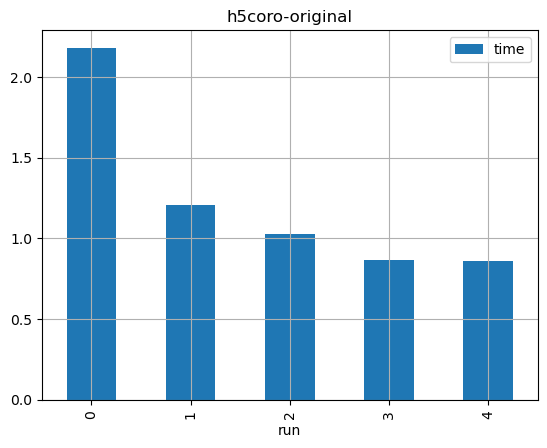

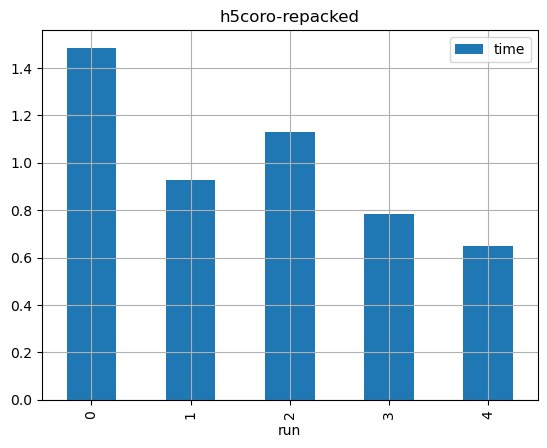

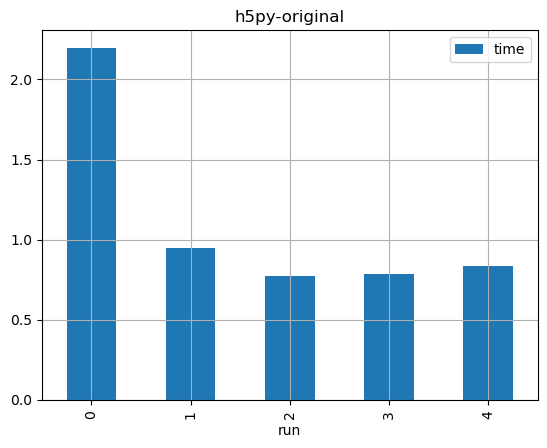

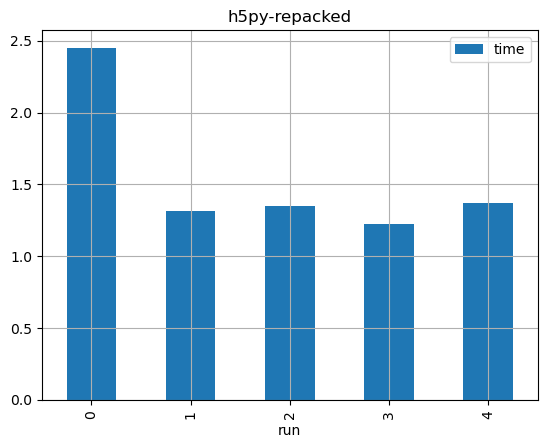

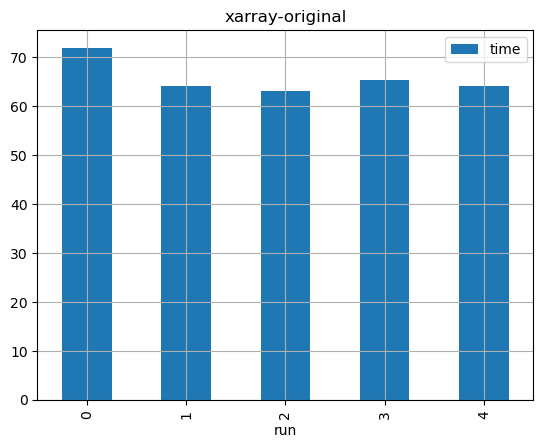

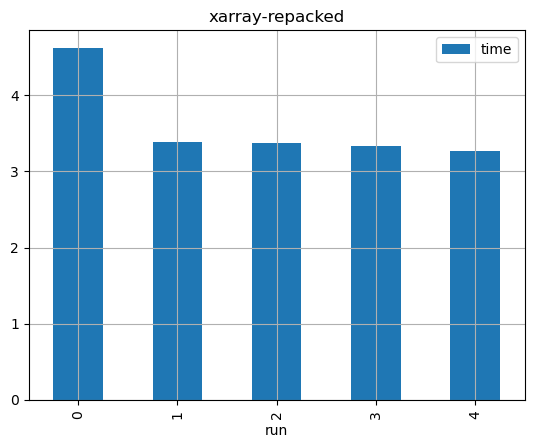

In [93]:
# df.set_index(["tool","file"], inplace=True)

df_filtered = df.loc[:, df.columns!='mean']

for name, group in df_filtered.groupby(['tool', 'format']):
    # print(name)
    group.plot.bar(x="run", y="time", legend=True, title='-'.join(name), grid=True, subplots=False, sharex=True, sharey=True)